In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Factor-based Model Long/Short Global Macro Strategy:

The aim of this project is to build a factor-based model Long/Short Global Macro Strategy with a Beta Target and to evaluate its sensitivity to variations of Beta and look back periods. We use following 13 ETFs to build the portfolio:      
> 1. CurrencyShares Euro Trust (FXE)
2. iShares MSCI Japan Index (EWJ)
3. SPDR GOLD Trust (GLD)
4. Powershares NASDAQ-100 Trust (QQQ)
5. SPDR S&P 500 (SPY)
6. iShares Lehman Short Treasury Bond (SHV)
7. PowerShares DB Agriculture Fund (DBA)
8. United States Oil Fund LP (USO)
9. SPDR S&P Biotech (XBI)
10. iShares S&P Latin America 40 Index (ILF)
11. SPDR S&P Emerging Middle Est & Africa (GAF)
12. iShares MSCI Pacific ex-Japan Index Fund (EPP)
13. SPDR DJ Euro Stoxx 50 (FEZ)

As defined in the project guidlines we decompose the returns on the different ETFs in 3-Factor French Fama Model.The factors are namely:
> 1. Market Risk
2. the outperformance of small versus big companies (Small Vs Large Market Capital)
3. the outperformance of high book/market versus small book/market companies (Value vs Growth companies)

The equation of the 3-Factor French Fama Model is as follows:

$ r = r_f + \beta_3 (r_m - r_f) + b_s r_{SMB} + b_v r_{HML} + \alpha $

While we use Global Diversified assets in construction of portfolio, we still use S&P 500 as benchmark. The purpose of using S&P500 as benchmark is to identify whether the active management is worth the extra-cost.

Before moving towards the process of finding optimal weights let's analyze the data and visualize the correlations between different asset classes.

In [18]:
ticker = ["FXE","EWJ","GLD","QQQ","SHV","DBA","USO","XBI","ILF","GAF","EPP","FEZ"]


# for etf in ticker:
#     data = yf.download(etf, start="2000-01-01")
#     data.to_csv(etf)

data = pd.read_csv("adj_close.csv")
data.Date=pd.to_datetime(data.Date)
data.set_index("Date",inplace=True)
data.applymap(lambda x: round(x,4)).tail()

,SPY,FXE,EWJ,GLD,QQQ,SHV,DBA,USO,XBI,ILF,GAF,EPP,FEZ,Mkt-RF,SMB,HML,RF
Date,,,,,,,,,,,,,,,,,
2016-10-14,207.0017,106.73,48.1600,119.36,115.5522,109.0176,20.18,11.44,59.3450,28.9126,55.0184,38.9873,31.2419,0.01,-0.35,0.57,0.001
2016-10-17,206.2830,107.08,48.1991,119.68,115.2365,109.0176,20.28,11.37,58.8567,29.1964,55.5249,38.8842,31.1934,-0.29,-0.05,0.14,0.001
2016-10-18,207.5748,106.82,48.4722,120.42,116.2624,109.0077,20.27,11.45,59.6738,29.9204,56.3138,39.3246,31.5231,0.60,-0.16,0.03,0.001
2016-10-19,208.1284,106.73,48.6283,121.11,116.2525,109.0275,20.26,11.66,58.6076,30.0965,57.0637,39.5026,31.5813,0.25,0.04,0.91,0.001
2016-10-20,207.7399,106.29,49.0577,120.74,116.1144,108.9978,20.21,11.43,59.6738,30.3216,57.0637,39.2403,31.6977,-0.16,-0.02,-0.11,0.001


### Plot of Price Time Series:

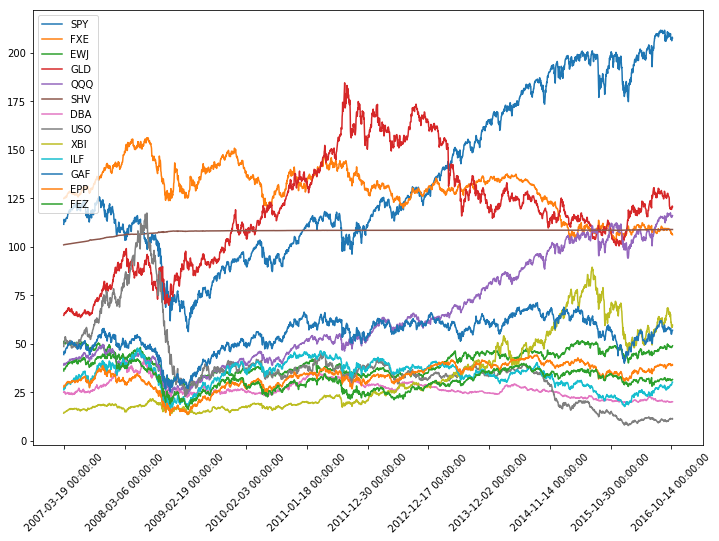

In [3]:
#plot the price first

plt.figure(figsize=(12,8))
plt.plot(data.SPY.values,label="SPY")
for i in ticker:
    plt.plot(data[i].values,label=i)
plt.legend()
plt.xticks(range(0,len(data),len(data)//10),data.index[range(0,len(data),len(data)//10)],rotation=45)
plt.show()

### Correlation Heat Map:
We plot the heat map of correlations between 13 different ETFs to visualize the effect of diversification benefit of the portfolio assets. As we can see from heat map S&P500 is negatively correlated to Currency, Agriculture, Oil, and Latin American Markets. That is adding commodities and emerging market assets will provide the better diversification. While S&P500 is uncorrelated to the Gold. On the otherhand, as expected S&P500 is highly correlated to QQQ and S&P Biotech ETFs. 

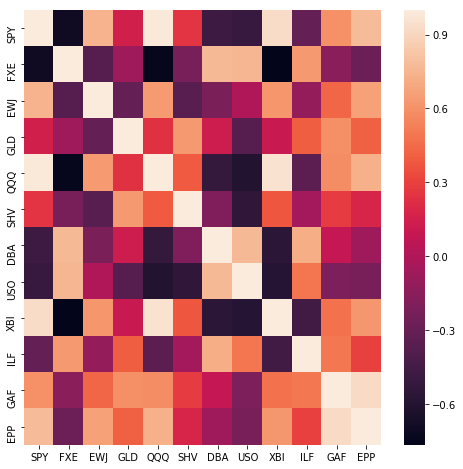

In [16]:
correl = data.iloc[:,:12]
corr = correl.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

### Note Worth Point:
As seen from graph below, Lehman Short Treasury Bond ETF, unlike the other ETFs has very low relatively.

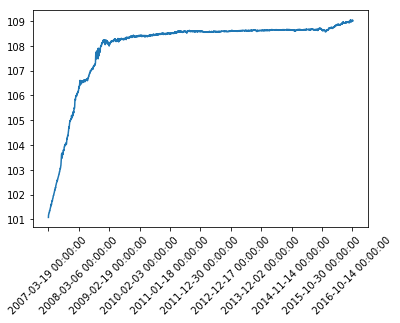

In [4]:
#plot SHV
plt.plot(data["SHV"].values)
plt.xticks(range(0,len(data),len(data)//10),data.index[range(0,len(data),len(data)//10)],rotation=45)
plt.show()

In [5]:
from sklearn.linear_model import LinearRegression
from cvxopt import solvers
from cvxopt import matrix
from scipy.stats import norm

class factor_model():
    
    def __init__(self,data,window,lamb_da):
        self.data = data
        self.window = window
        self.lamb_da = lamb_da
    
    def find_data(self, start, end):
        """
        find data in our dataset between a given period
        
        args:
            start,end: pd.datatime
            
        return:
            subset of our data
            
        """
        while not (start in self.data.index):
            start = start+pd.Timedelta(1,unit="d")
        
        #exclude end
        end = end-pd.Timedelta(1,unit="d")
        while not (end in self.data.index):
            end = end-pd.Timedelta(1,unit="d")
        
        return self.data.loc[start:end,:]
    
    def estimation(self,start):
        """
        estimate mu and Q in a certain period
        
        args:
            start: pd.datetime
            window: int, length of the window
        
        return:
            beta:
            mu:
            Q:
        """
        end = start+pd.Timedelta(self.window,unit="d")
        subset = self.find_data(start,end)
        #print(len(subset))
        ETFs = subset.iloc[:,:-4]
        factors = subset.iloc[1:,-4:]
        
        # calculate daily returns, including benchmark
        re_turn = (1-ETFs.shift()/ETFs).dropna()
        assert sum(factors.index != re_turn.index) == 0
        
        # calculate expected returns, without benchmark
        self.mu = re_turn.mean()[1:].values
        
        # calculate betas according to CAPM
        beta = []
        for i in range(1,len(ETFs.columns)):
            lr = LinearRegression()
            #fit benchmark to i-th ETF's excess return
            lr.fit(re_turn.iloc[:,0].values.reshape(-1,1),
                   (re_turn.iloc[:,i]-factors.loc[:,"RF"]).values.reshape(-1,1))
            beta.append(float(lr.coef_))
        self.beta = np.array(beta)
        
        # estimate covariance matrix according to FF-3 factors model
        B = np.zeros((len(ETFs.columns)-1,3))
        D = []
        for i in range(1,len(ETFs.columns)):
            lr = LinearRegression()
            #fit factors' data to i-th ETF's excess return
            x = factors.iloc[:,:-1].values
            y = (re_turn.iloc[:,i]-factors.loc[:,"RF"]).values.reshape(-1,1)
            lr.fit(x,y)
            y_hat = lr.predict(x)
            
            D.append((y-y_hat).std()**2)     
            B[i-1,:] = lr.coef_
        
        D = np.diagflat(D)
        
        #covariance matrix of factors
        cov = factors.iloc[:,:-1].cov()
        
        #calculate Q
        self.Q = B@cov@B.T+D
        

    
    def initialize_benchmark_weights(self):
        # solve the benchmark optimization problem
        # self.weights 
        
        n=len(self.mu)
        #minimize
        P=matrix(self.Q+self.lamb_da*np.eye(n))
        # W_p for initial benchmark problem is equal weights
        q=matrix(-self.lamb_da*np.ones(n)/n)
        
        #equal constraint: sum of xi's equals 1
        A=matrix(np.row_stack((np.ones(n),self.mu)))
        b=matrix([1.0,0.15/250])
        #inequal constraint: -2<=xi<=2
        G=np.vstack((np.eye(n),-np.eye(n)))
        G=matrix(G)
        h=matrix([2.0 for i in range(2*n)])

        solvers.options['show_progress'] = False
        sol=solvers.qp(P=P,q=q,G=G,h=h,A=A,b=b)

        self.bench_weights = np.array(sol["x"]).ravel()
        return np.array(sol["x"]).ravel()
    
    def bench_weights_update(self):
        n=len(self.mu)
        #minimize
        P=matrix(self.Q+self.lamb_da*np.eye(n))
        # W_p for initial benchmark problem is equal weights
        q=matrix(-self.lamb_da*self.bench_weights)
        
        #equal constraint: sum of xi's equals 1
        A=matrix(np.row_stack((np.ones(n),self.mu)))
        b=matrix([1.0,0.15/250])
        #inequal constraint: -2<=xi<=2
        G=np.vstack((np.eye(n),-np.eye(n)))
        G=matrix(G)
        h=matrix([2.0 for i in range(2*n)])

        solvers.options['show_progress'] = False
        sol=solvers.qp(P=P,q=q,G=G,h=h,A=A,b=b)

        self.bench_weights = np.array(sol["x"]).ravel()
        return np.array(sol["x"]).ravel()        

    def weights_update(self,target_beta):
        
        #after update our estimation for mu and Q, we update portfolio weights

        n=len(self.mu)
        
        #minimize
        P=matrix(2*self.lamb_da*np.eye(n))
        # W_p for updating problem is previous weights
        q=matrix(-2*self.lamb_da*self.weights-self.mu)
        
        #equal constraint: sum of xi's equals 1
        A=matrix(np.row_stack((np.ones(n),self.beta)))
        b=matrix([1.0,target_beta])
        #inequal constraint: -2<=xi<=2
        G=np.vstack((np.eye(n),-np.eye(n)))
        G=matrix(G)
        h=matrix([2.0 for i in range(2*n)])

        solvers.options['show_progress'] = False
        sol=solvers.qp(P=P,q=q,G=G,h=h,A=A,b=b)

        self.weights = np.array(sol["x"]).ravel()
        #return np.array(sol["x"])      
                    
        
    def backtest(self,target_beta,rebalancing_period=20,do_plot=False):
        
        ndays = (self.data.index[-1]-self.data.index[0]).days
        n = (ndays-self.window)//rebalancing_period
        end = [self.data.index[-1]-pd.Timedelta(i*rebalancing_period,unit="d") for i in range(n)][::-1]
        mid = [i-pd.Timedelta(rebalancing_period,unit="d") for i in end]
        start = [i-pd.Timedelta(self.window,unit="d") for i in mid]
        assert start[-1]>=self.data.index[0]
        
        # initialize
        self.estimation(start[0])
        self.weights = self.initialize_benchmark_weights()
        
        # 1st portfolio
        subset = self.find_data(mid[0],end[0]).iloc[:,1:-4]
        portfolio = subset.values@np.column_stack((self.weights,self.bench_weights))
        value = pd.DataFrame(portfolio,columns = ["portfolio","Min_vol"],index=subset.index)

        
        for i in range(1,len(start)):
            self.estimation(start[i])
            
            self.weights_update(target_beta)
            cache = self.bench_weights_update()
            #print(self.bench_weights@self.mu)    all = 0.006
            #print(self.weights)
            subset = self.find_data(mid[i],end[i]).iloc[:,1:-4]
            portfolio = subset.values@np.column_stack((self.weights,self.bench_weights))
            a = pd.DataFrame(portfolio,columns = ["portfolio","Min_vol"],index=subset.index)
            #each time we rebalance our portfolio, we should have some cash in/out, so we adjust portfolio price
            a.portfolio = a.portfolio-(a.portfolio.iloc[0]-value.portfolio.iloc[-1])
            a.Min_vol = a.Min_vol-(a.Min_vol.iloc[0]-value.Min_vol.iloc[-1])
            value = value.append(a)
        
        
        #now we get price series of portfolio and each ETF
        value = value.join(self.data.iloc[:,:-4],how="inner")
        
        #suppose we buy 100$ at the beginning
        shares = 100/value.iloc[0,:]
        pnl = shares*(value - value.shift()).dropna()
        
        #1. daily cumsum pnl
        cum_pnl = pnl.cumsum()
        final_pnl = cum_pnl.iloc[-1,:]
        
        figs=[]
        f1 = plt.figure()
        plt.plot(cum_pnl.portfolio,label="porfolio_"+str(target_beta))
        plt.plot(cum_pnl.SPY,label="SNP500")
        plt.plot(cum_pnl.Min_vol,label="Min vol")
        plt.legend()
        plt.title("PnL")
        figs.append(f1)
        """
        plt.figure(figsize=(12,8))
        for i in range(pnl.shape[1]):
            plt.plot(pnl.cumsum().iloc[:,i],label=pnl.columns[i])
        plt.legend()
        plt.xticks(rotation=45)
        """
        
        
        # daily return 
        re_turn = (value/value.shift()-1).dropna()
        
        if do_plot == True:
            fig2, ax = plt.subplots(nrows=5, ncols=3,figsize=(12,8))
            num=0
            title =list(re_turn.columns)
            plt.tight_layout()
            for row in range(5):
                for col in range(3):
                    sns.distplot(re_turn.iloc[:,num], ax=ax[row, col])
                    plt.title(title[num])
                    num+=1
                    if num == 14:
                        break
            figs.append(fig2)


#         for i in range(re_turn.shape[1]):
#             plt.subplots(5,3,i+1)
#             sns.distplot(re_turn.iloc[:1])
#             title =list(re_turn.columns)
#             plt.title(title[i])
#             plt.show()

        #2. (annualized) Daily Mean Geometric Return
        DMGR = ((re_turn+1).prod()**(1/len(re_turn))-1)*250
        
        #3. (annualized) Daily Min Return
        DMinR = (re_turn.min())*250
        
        #4. Max 10 days Drawdown
        daily_rolling_drawdown = value/value.rolling(window=10,min_periods=1,center=False).max()-1
        M10DD = daily_rolling_drawdown.rolling(window=10,min_periods=1,center=False).min()
        M10DD = -M10DD.min()
        
        
        #5. annualized volatility
        vol = (value/value.shift()-1).dropna().std()
        annualized_vol = vol*np.sqrt(250)
        
        #6. Sharpe ratio
        sharpe = (re_turn.mean()*250-self.data.loc[:,"RF"].values.mean())/annualized_vol
        
        #7. Skewness
        s = re_turn.skew()
        
        #8. Kurtosis
        k = re_turn.kurt()
        
        #9. Modified VaR
        z=0.95
        M_Var = (re_turn.mean()+(z+(z**2+1)*s/6+(z**3-3*z)*k/24-(2*z**3-5*z)*s**2/36)*vol)*250
        
        #10. CVaR
        alpha = 1-z
        CVaR = (alpha**(-1)*norm.pdf(norm.ppf(alpha))*vol-re_turn.mean())*250
        
        mat1 = np.row_stack((final_pnl,DMGR,DMinR,M10DD,annualized_vol,sharpe,s,k,M_Var,CVaR))
        column = list(re_turn.columns[1:])
        column.insert(0,"portfolio_"+str(target_beta))
        summary1 = pd.DataFrame(mat1,columns=column,index=["cumulative pnl",
                                                                  "Daily Mean Geometric Return",
                                                                 "Daily Min Return",
                                                                 "Max 10 days Drawdown",
                                                                 "volatility",
                                                                 " Sharpe ratio",
                                                                 "Skewness",
                                                                 "Kurtosis",
                                                                 "Modified VaR","CVaR"])
        return summary1, figs
        

        
        


## factor_model Class description:
This factor_model class is the main tool we use in this project. In the object we can specify our lookback period(short_term = 60, mid_term = 120, long_term = 200), lamb_da(which is the inverse tolerance of portfolio weights changes to previous one, however we simply fix it to 2), and target beta(0.5, 1.0, 1.5). In back test method, we can back test the portfolio dynamically, where we also fix rebalancing period to be 20 days. The logic is we first initialize portfolio weights as the second benchmark portfolio (target return=15% and minimum volatility) and iteratively update estimations of securities' returns, covariance matrix, and beta coefficients, then accordingly solve for optimization problems to get weights of our portfolio as well as Minimum Variance portfolio. Finally, we can obtain a table of performance analysis of all considered portfolios.

## Results and Analysis:

##### We present the results in the form of different time periods viz. Financial Crisis Period and Post-Financial Crisis Period, and  different exposures to market $\beta_m$ = 0.5, 1.0, 1.5, with summary of performance and risk matrix for Portfolios with $\beta_m$ exposure of 0.5, 1.0, and, 1.5, S&P500 index as Benchmark and Portfolio with minimum variance and target return of 15% per annum.  
##### We also change the look back period to calculate rebalacing weights from 60, 120, 200 days and compare the results. 

## Results: Overall Time Period ( March 2007 to Oct 2016):

We plot the daily P&L for portfolio with USD 100 investment at day one in Portfolio with $\beta_m$ = 0.5, 1.0, 1.5 Vs S&P500 and Minimim Variance Portfolio. We also plot the return distribution for all the portfolio constituents and Portfolio and tabulate risk-return porfolio analytics for all components    

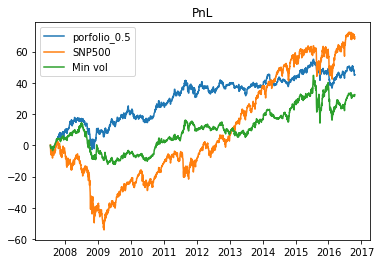

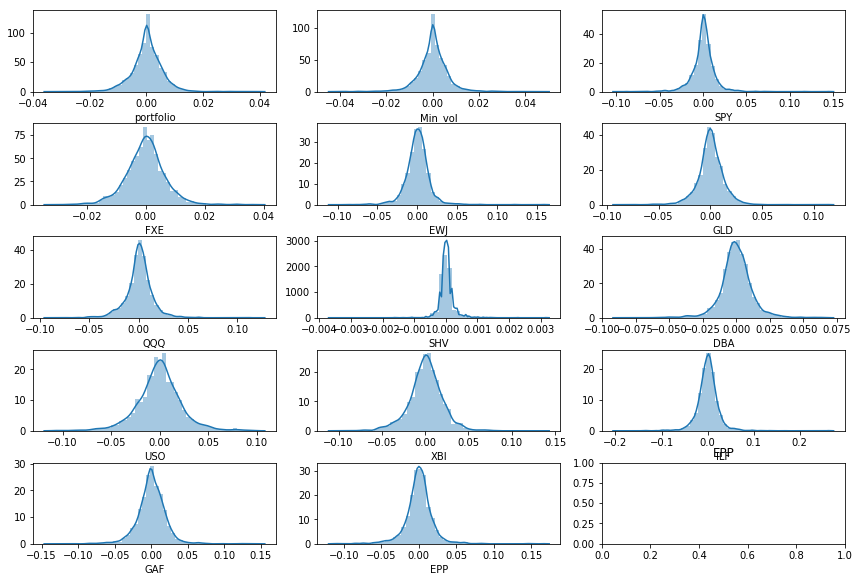

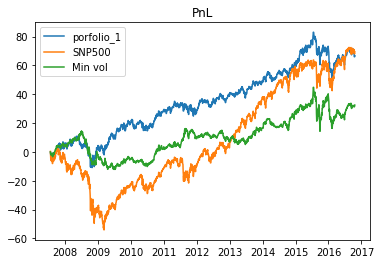

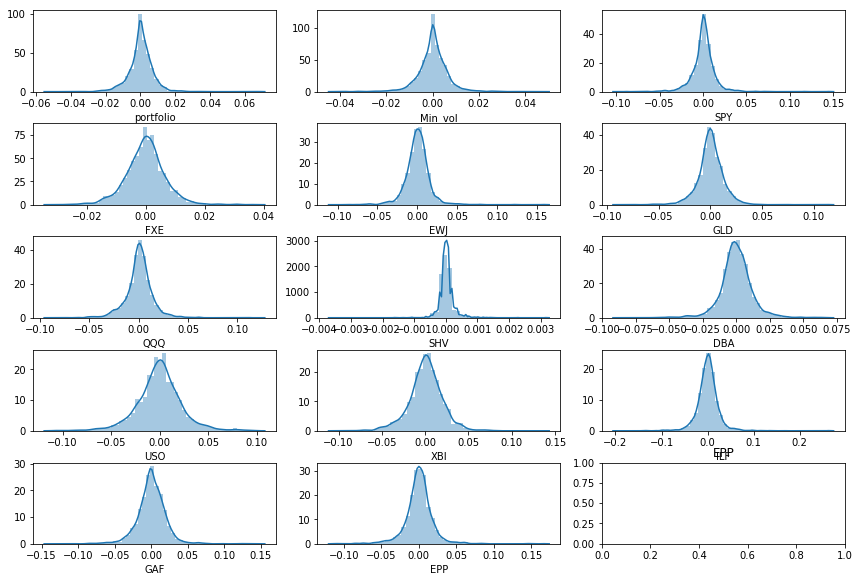

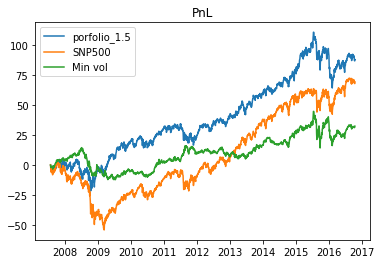

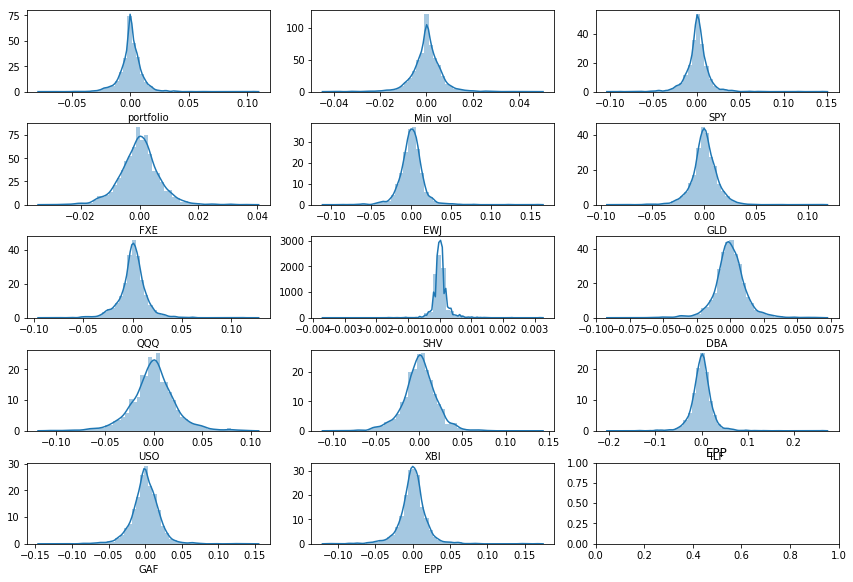

In [6]:
summary_list=[]
for i in [0.5,1,1.5]:
    model = factor_model(data,120,2)
    results,figs = model.backtest(i,do_plot=True)
    summary_list.append(results.applymap(lambda x: round(x,4)))
    plt.show(figs[0])
    plt.show(figs[1])

In [7]:
display(summary_list[0])
display(summary_list[1])
display(summary_list[2])

,portfolio_0.5,Min_vol,SPY,FXE,EWJ,GLD,QQQ,SHV,DBA,USO,XBI,ILF,GAF,EPP,FEZ
cumulative pnl,45.2729,32.4592,69.4782,-18.6970,-3.6165,79.2098,156.7866,6.0329,-20.6229,-79.5439,263.1139,-14.6122,12.1362,19.7297,-24.8783
Daily Mean Geometric Return,0.0401,0.0302,0.0566,-0.0222,-0.0040,0.0626,0.1012,0.0063,-0.0248,-0.1702,0.1384,-0.0169,0.0123,0.0193,-0.0307
Daily Min Return,-8.3091,-10.4487,-24.6120,-7.6873,-26.0193,-21.9521,-22.3891,-0.9050,-21.5149,-26.7114,-25.2530,-48.6667,-34.0566,-28.0545,-30.5293
Max 10 days Drawdown,0.0729,0.1388,0.2495,0.0814,0.2411,0.2023,0.2327,0.0036,0.2282,0.2490,0.2470,0.3833,0.2731,0.3041,0.2699
volatility,0.0866,0.1023,0.2136,0.1051,0.2358,0.1996,0.2207,0.0040,0.1929,0.3588,0.3038,0.3655,0.3107,0.2960,0.3138
Sharpe ratio,0.4798,0.3237,0.3610,-0.1806,0.0911,0.4021,0.5584,0.9953,-0.0437,-0.3011,0.6000,0.1297,0.1876,0.2053,0.0517
Skewness,0.0051,-0.1300,0.2186,0.0995,0.4187,-0.0619,0.0873,-0.3180,-0.2074,-0.0049,-0.0582,0.3937,0.0577,0.2640,0.1483
Kurtosis,4.2865,6.3200,13.5175,2.1871,11.3917,6.2321,7.3485,40.0314,5.4409,2.1267,2.3876,13.7766,6.8596,9.2899,7.5568
Modified VaR,0.8592,0.6588,-0.2547,1.3136,0.5895,1.3865,1.4106,-0.1507,1.3240,4.2736,3.7088,-0.2735,2.0210,1.3186,1.8616
CVaR,2.7793,3.3007,6.8857,3.4432,7.6667,6.4257,7.0734,0.1250,6.2972,11.8087,9.7245,11.8714,10.0728,9.5905,10.2160


,portfolio_1,Min_vol,SPY,FXE,EWJ,GLD,QQQ,SHV,DBA,USO,XBI,ILF,GAF,EPP,FEZ
cumulative pnl,66.6806,32.4592,69.4782,-18.6970,-3.6165,79.2098,156.7866,6.0329,-20.6229,-79.5439,263.1139,-14.6122,12.1362,19.7297,-24.8783
Daily Mean Geometric Return,0.0548,0.0302,0.0566,-0.0222,-0.0040,0.0626,0.1012,0.0063,-0.0248,-0.1702,0.1384,-0.0169,0.0123,0.0193,-0.0307
Daily Min Return,-13.0086,-10.4487,-24.6120,-7.6873,-26.0193,-21.9521,-22.3891,-0.9050,-21.5149,-26.7114,-25.2530,-48.6667,-34.0566,-28.0545,-30.5293
Max 10 days Drawdown,0.1022,0.1388,0.2495,0.0814,0.2411,0.2023,0.2327,0.0036,0.2282,0.2490,0.2470,0.3833,0.2731,0.3041,0.2699
volatility,0.1100,0.1023,0.2136,0.1051,0.2358,0.1996,0.2207,0.0040,0.1929,0.3588,0.3038,0.3655,0.3107,0.2960,0.3138
Sharpe ratio,0.5325,0.3237,0.3610,-0.1806,0.0911,0.4021,0.5584,0.9953,-0.0437,-0.3011,0.6000,0.1297,0.1876,0.2053,0.0517
Skewness,0.1527,-0.1300,0.2186,0.0995,0.4187,-0.0619,0.0873,-0.3180,-0.2074,-0.0049,-0.0582,0.3937,0.0577,0.2640,0.1483
Kurtosis,7.8532,6.3200,13.5175,2.1871,11.3917,6.2321,7.3485,40.0314,5.4409,2.1267,2.3876,13.7766,6.8596,9.2899,7.5568
Modified VaR,0.6668,0.6588,-0.2547,1.3136,0.5895,1.3865,1.4106,-0.1507,1.3240,4.2736,3.7088,-0.2735,2.0210,1.3186,1.8616
CVaR,3.5270,3.3007,6.8857,3.4432,7.6667,6.4257,7.0734,0.1250,6.2972,11.8087,9.7245,11.8714,10.0728,9.5905,10.2160


,portfolio_1.5,Min_vol,SPY,FXE,EWJ,GLD,QQQ,SHV,DBA,USO,XBI,ILF,GAF,EPP,FEZ
cumulative pnl,88.0883,32.4592,69.4782,-18.6970,-3.6165,79.2098,156.7866,6.0329,-20.6229,-79.5439,263.1139,-14.6122,12.1362,19.7297,-24.8783
Daily Mean Geometric Return,0.0678,0.0302,0.0566,-0.0222,-0.0040,0.0626,0.1012,0.0063,-0.0248,-0.1702,0.1384,-0.0169,0.0123,0.0193,-0.0307
Daily Min Return,-18.6652,-10.4487,-24.6120,-7.6873,-26.0193,-21.9521,-22.3891,-0.9050,-21.5149,-26.7114,-25.2530,-48.6667,-34.0566,-28.0545,-30.5293
Max 10 days Drawdown,0.1379,0.1388,0.2495,0.0814,0.2411,0.2023,0.2327,0.0036,0.2282,0.2490,0.2470,0.3833,0.2731,0.3041,0.2699
volatility,0.1551,0.1023,0.2136,0.1051,0.2358,0.1996,0.2207,0.0040,0.1929,0.3588,0.3038,0.3655,0.3107,0.2960,0.3138
Sharpe ratio,0.4998,0.3237,0.3610,-0.1806,0.0911,0.4021,0.5584,0.9953,-0.0437,-0.3011,0.6000,0.1297,0.1876,0.2053,0.0517
Skewness,0.1696,-0.1300,0.2186,0.0995,0.4187,-0.0619,0.0873,-0.3180,-0.2074,-0.0049,-0.0582,0.3937,0.0577,0.2640,0.1483
Kurtosis,10.9719,6.3200,13.5175,2.1871,11.3917,6.2321,7.3485,40.0314,5.4409,2.1267,2.3876,13.7766,6.8596,9.2899,7.5568
Modified VaR,0.3134,0.6588,-0.2547,1.3136,0.5895,1.3865,1.4106,-0.1507,1.3240,4.2736,3.7088,-0.2735,2.0210,1.3186,1.8616
CVaR,4.9789,3.3007,6.8857,3.4432,7.6667,6.4257,7.0734,0.1250,6.2972,11.8087,9.7245,11.8714,10.0728,9.5905,10.2160


In [8]:
Summary2 = pd.concat((summary_list[0].iloc[:,0],summary_list[1].iloc[:,0],summary_list[2].iloc[:,:3]), axis =1)
display(Summary2)

,portfolio_0.5,portfolio_1,portfolio_1.5,Min_vol,SPY
cumulative pnl,45.2729,66.6806,88.0883,32.4592,69.4782
Daily Mean Geometric Return,0.0401,0.0548,0.0678,0.0302,0.0566
Daily Min Return,-8.3091,-13.0086,-18.6652,-10.4487,-24.6120
Max 10 days Drawdown,0.0729,0.1022,0.1379,0.1388,0.2495
volatility,0.0866,0.1100,0.1551,0.1023,0.2136
Sharpe ratio,0.4798,0.5325,0.4998,0.3237,0.3610
Skewness,0.0051,0.1527,0.1696,-0.1300,0.2186
Kurtosis,4.2865,7.8532,10.9719,6.3200,13.5175
Modified VaR,0.8592,0.6668,0.3134,0.6588,-0.2547
CVaR,2.7793,3.5270,4.9789,3.3007,6.8857


### Analysis ( March 2007 to Oct 2016):
As seen from the tables above SPDR S&P Biotech (XBI) ETF is best performing asset with 13% annual return while Oil is worst performer with -17% annual return. iShares Lehman Short Treasury Bond (SHV) ETF has lowest volatility of 0.4% and Oil has highest volatility of 35%. iShares MSCI Pacific ex-Japan Index Fund (EPP) exhibits worst Max 10 days Drawdown of 0.38.

Now let's turn to portfolios and analyze the performance. Portfolio with $\beta_m$ exposure of 1.5 (portfolio_1.5) performs best on basis of annualized return basis with return equal to 6.7%, 1% outperformace comapred to S&P500. While portfolio_1.5 has higher volatility than other portfolios, it still has lower volatility than S&P500 index, because of the diversification benefit achieved by investing in Global Portfolio. Additionally, for same reasons, the Max Drawdown and Daily Min Return of portfolio_1.5 are better than S&P500.

On the basis of Sharpe Ratio Portfolio with $\beta_m$ exposure of 1.0 (portfolio_1) is best with Sharpe Raito of 0.53. 

The true benefit of Global Diversification can be seen clearly from Skewness and Kurtosis, the porfolio with highest exposure to $\beta_m$ has less fat tails and lower drawdowns than S&P500. 

In [9]:
def summary_without_distplot(data,look_back,dataname):
    summ = []
    for i in [0.5,1,1.5]:
        model = factor_model(data,look_back,2)
        fig = plt.figure(i)
        results,fig = model.backtest(i)
        summ.append(results.applymap(lambda x: round(x,4)))
        plt.savefig(dataname+str(i)+str(look_back)+".png")
    Summary2 = pd.concat((summ[0].iloc[:,0],summ[1].iloc[:,0],summ[2].iloc[:,:3]), axis =1)
    return Summary2

In [10]:
# we split the data by the end of 2009
crisis = data.loc[:'2009-12-31']
post_crisis = data.loc['2010-01-04':]
dictionary = {"crisis":crisis,"post_crisis":post_crisis}

summary = []

for i in dictionary:
    for j in [60,120,200]:
        a= summary_without_distplot(dictionary[i],j,i)
        summary.append(a)
        
        

Results for crisis data with lookback=60


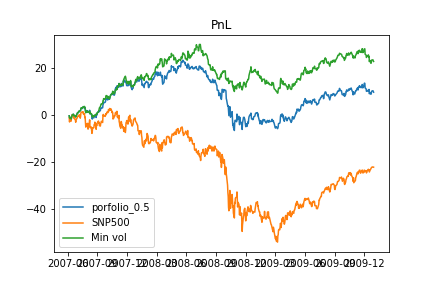

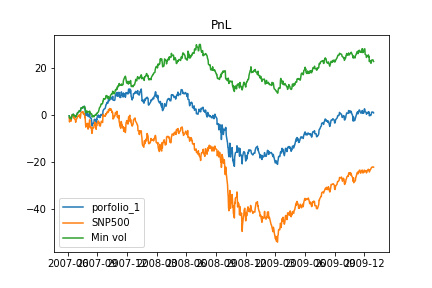

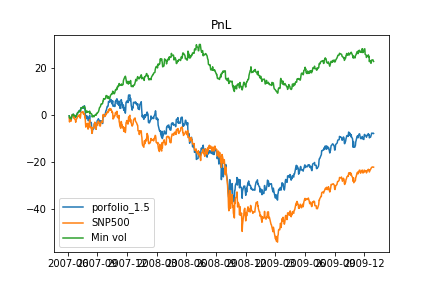



Results for crisis data with lookback=120


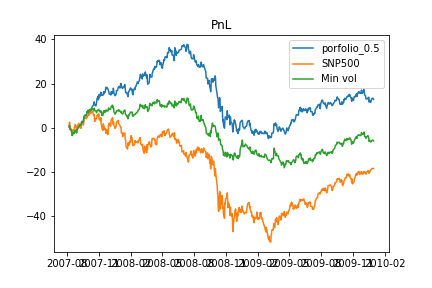

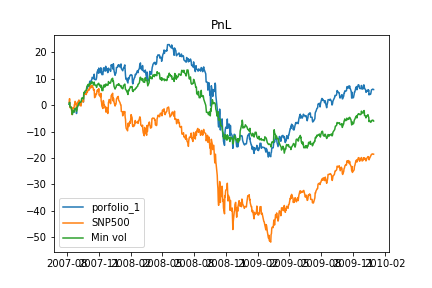

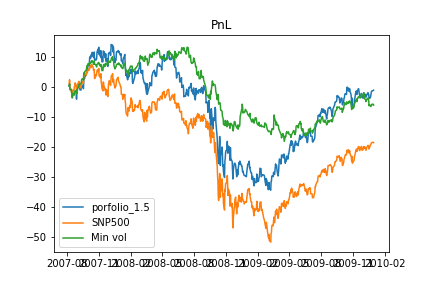



Results for crisis data with lookback=200


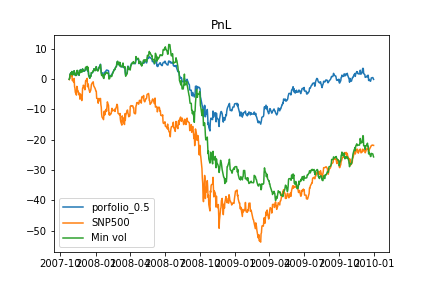

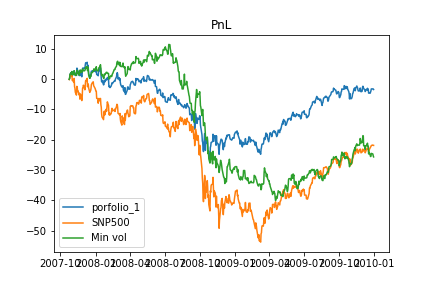

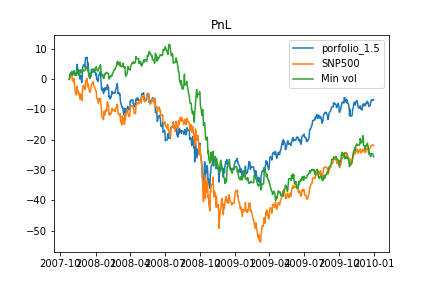



Results for post_crisis data with lookback=60


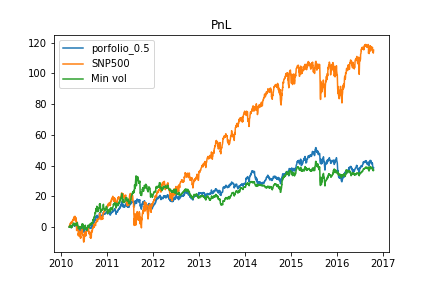

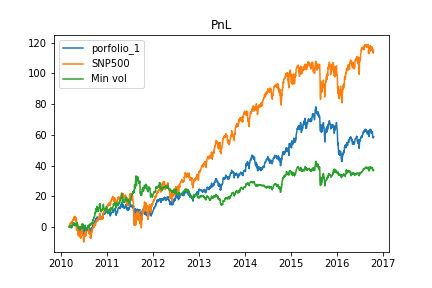

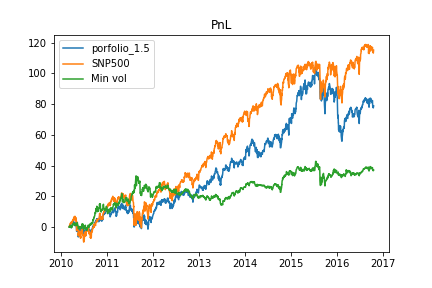



Results for post_crisis data with lookback=120


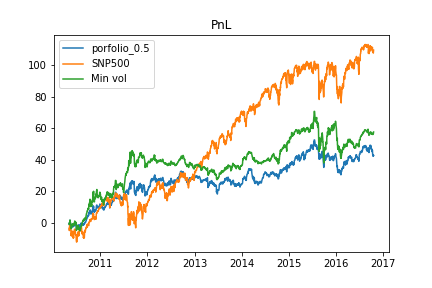

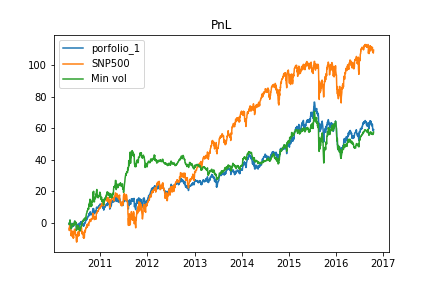

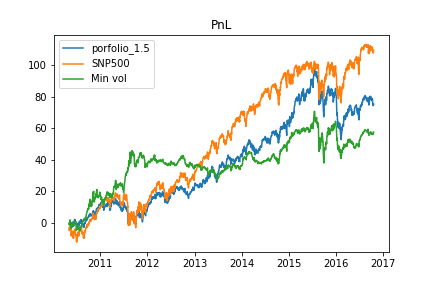



Results for post_crisis data with lookback=200


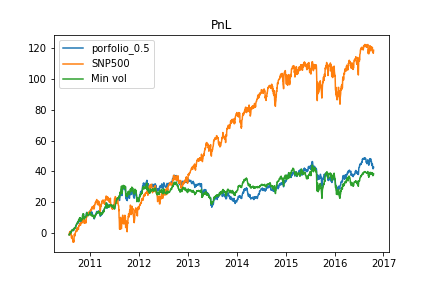

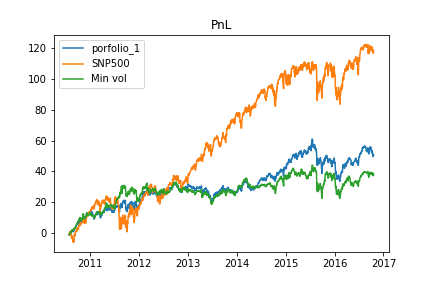

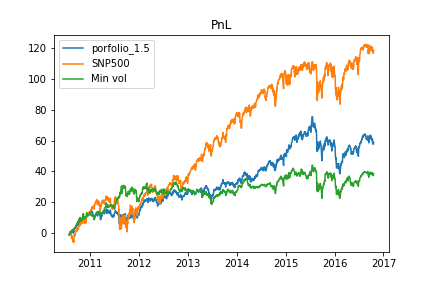

In [66]:
from IPython.display import Image
from matplotlib.pyplot import figure, imshow, axis

l=[]
for i in ["crisis","post_crisis"]:
    for j in [60,120,200]:
        l.append((i,j))
        
for i in range(6):
    print("Results for {} data with lookback={}".format(l[i][0],l[i][1]))
    #display(summary[i])
    for j in [0.5,1,1.5]:
        file = l[i][0]+str(j)+str(l[i][1])+".png"
        display(Image(filename = file))
    print("\n")
         

### Analysis Crisis Period: ( March 2007 to Dec 2009):

Untill now we observed the risk-return analysis for the entire period of almost 10 years with look back frequency of 120 days. Now let's split our dataset in two sections. The crisis era i.e. from March 2007 to Dec 2009 and post crisis era i.e. from Jan 2010 to end of 2016. In doing so we dive deeper by changing the look-back period, to calculate rebalancing weights every 20 trading days, into short term (ST)- 60 days look back, medium term (MT)- 120 days look back, and long term (LT)- 200 days look back period.

Now lets first analyze how risk-return profile of protfolios look like during the crisis period and then assess the sensitivity of the portfolio returns to number of look back days.

##### Crisis Period Portfolio Risk-Return Profile: 

During the crisis period the portfolio with Minimum Variance perfoms best when we choose Short Term volatility as measure of risk. While overall $\beta_m$ exposure equal to 0.5 with Short Term look back i.e. protofolio less exposed to systematic risk factors yeilds highest annualized return compared to any other portfolio with MT and LT look back periods. Clearly, all the portfolios have fatter tails and negative skews with worse risk analytics parameters than entire period analysis.

##### Effect of Change in Look-Back Period:

Effect of change in look-back period on risk return profile of portfolios is interesting. Let's comment on each protfolios senstitvity to look back period.

> ###### Portfolio with $\beta$ of 0.5 (portfolio_0.5):

Protfolio with 0.5 $\beta$ perfomrs best for 120 days i.e. Medim Term look back period with Sharpe Ratio of 0.3505 and annualized return of 4.9% and beats S&P500 returns by 13.5%. While return volatiliy is lowest for ST look back period. The protfolio_0.5 also has best values on risk matrices like Daily Min Return, Max 10 days Drawdown than any other portfolio. 

> ###### Portfolio with $\beta$ of 1.0 (portfolio_1):

Protfolio with 1.0 $\beta$ perfomrs best for 120 days i.e. Medim Term look back period with Sharpe Ratio of 0.1814 and annualized return of 2.4% and beats S&P500 returns by almost 10%. We think because the volatility in the market returns was very high in crisis period there was large changes in potfolio weights as we change the look back period. It seem that not looking far enough and looking back too far distorted the true nature of market performance. This portoflio performs better than S&P500 even though it has exposure to market risk factor because of the fact that this portfolio is well diversified Global Portfolio and has safe assets like glod and tresayry that performs best in time of stress.

> ###### Portfolio with $\beta$ of 1.5 (portfolio_1.5):

This is worst portfolio to hold during the crisis period. This protfolio fails to beat S&P500 for LT look back period while for ST and MT look back periods it performs slightly better than S&P500. This just proves that it is worst idea to hold portfolio with over-exposure to systematic risk.  

> ###### Minimum Variance Portfolio (Min_Vol):

This protfolio is both the best and the worst performer of the pack. Minimum variance performs the best with for ST look back period with return of 8% almost 16% outperformance comapred to to S&P500 with Sharpe Ratio of 0.7774. ST look back Min Vol protfolio has best Daily Min Return and Max 10 days Drawdown. While for LT look back Minumum Variance performs the worst with annualized return of -13% almost 2% underperformace comapred to S&P500.  

> ###### Conclusion:

In conclusion, it is best to hold Minimum Variance Portfolio with Short Term (60 days) look back period during crisis period. While the portfolio with Global Diversification and less exposure to market systematic risk factors is 2nd best.

In [79]:
hhh = list(np.repeat(np.array(['60 Days']),5))
hhh.extend(list(np.repeat(np.array(['120 Days']),5)))
hhh.extend(list(np.repeat(np.array(['200 Days']),5)))

hd = [np.array(hhh),np.array(['portfolio_0.5', 'portfolio_1', 'portfolio_1.5', 'Min_vol', 'SPY','portfolio_0.5', 'portfolio_1', 'portfolio_1.5', 'Min_vol', 'SPY','portfolio_0.5', 'portfolio_1', 'portfolio_1.5', 'Min_vol', 'SPY'])]
Summury_Crisis = pd.DataFrame(index=Summary2.index, columns = hd ) 
Summury_Crisis['60 Days'] = summary[0]
Summury_Crisis['120 Days'] = summary[1]
Summury_Crisis['200 Days'] = summary[2]
display(Summury_Crisis)

60 Days                                     \
                            portfolio_0.5 portfolio_1 portfolio_1.5  Min_vol   
cumulative pnl                     9.7860      1.0115       -7.7629  22.8509   
Daily Mean Geometric Return        0.0360      0.0039       -0.0311   0.0793   
Daily Min Return                  -8.7349    -13.8435      -23.0012  -6.7054   
Max 10 days Drawdown               0.0977      0.1315        0.1794   0.0467   
volatility                         0.1293      0.1746        0.2698   0.0989   
 Sharpe ratio                      0.2863      0.0675       -0.0076   0.7774   
Skewness                          -0.0229      0.0121        0.0189  -0.0191   
Kurtosis                           3.1194      5.0959        6.9683   1.0941   
Modified VaR                       1.4420      1.4841        1.6154   1.4179   
CVaR                               4.1719      5.6744        8.7936   3.1405   

                                          120 Days                            \
                                 SPY portfolio_0.5 portfolio_1 portfolio_1.5   
cumulative pnl              -22.0815       12.8000      5.9060       -0.9880   
Daily Mean Geometric Return  -0.0961        0.0497      0.0237       -0.0041   
Daily Min Return            -24.6120      -10.5833    -16.1446      -23.7875   
Max 10 days Drawdown          0.2495        0.1172      0.1533        0.2015   
volatility                    0.3179        0.1553      0.1952        0.2845   
 Sharpe ratio                -0.1671        0.3505      0.1814        0.1020   
Skewness                      0.4096       -0.0482     -0.0799        0.0415   
Kurtosis                      8.1774        2.1209      4.6452        6.4030   
Modified VaR                  2.0403        1.9254      1.7081        1.9781   
CVaR                         10.4123        5.0042      6.3242        9.2418   

                                                  200 Days              \
                            Min_vol      SPY portfolio_0.5 portfolio_1   
cumulative pnl              -6.0172 -18.5529       -0.1341     -3.4710   
Daily Mean Geometric Return -0.0256  -0.0846       -0.0006     -0.0160   
Daily Min Return            -7.8743 -24.6120       -9.1042    -14.7460   
Max 10 days Drawdown         0.0779   0.2495        0.1008      0.1344   
volatility                   0.1301   0.3257        0.1341      0.1810   
 Sharpe ratio               -0.1880  -0.1202        0.0079     -0.0387   
Skewness                     0.3389   0.4063        0.1514      0.3317   
Kurtosis                     2.0285   7.8403        3.7784      6.4817   
Modified VaR                 1.8320   2.2435        1.4633      1.5067   
CVaR                         4.2613  10.6556        4.3649      5.9038   

                                                             
                            portfolio_1.5  Min_vol      SPY  
cumulative pnl                    -6.8079 -25.6919 -21.9020  
Daily Mean Geometric Return       -0.0320  -0.1347  -0.1121  
Daily Min Return                 -21.9005 -10.2685 -24.6120  
Max 10 days Drawdown               0.1839   0.1461   0.2495  
volatility                         0.2694   0.2108   0.3373  
 Sharpe ratio                     -0.0117  -0.5688  -0.1863  
Skewness                           0.3562   0.2999   0.4174  
Kurtosis                           7.8436   2.1023   7.3591  
Modified VaR                       1.8036   2.8136   2.5368  
CVaR                               8.7828   6.9861  11.0572

### Analysis Post-Crisis Period: (Jan 2010 onwards):

Now lets first analyze how risk-return profile of protfolios look like during the post-crisis period and then assess the sensitivity of the portfolio returns to number of look back days.

##### Post-Crisis Period Portfolio Risk-Return Profile: 

The main characteristics of post crisis era until recently is very low volatility and upward trend in almost all asset classes except for oil and currencies. Definately there were few hickups here and there like Greece Debt Crisis, Brexit but these events have not change the long-term trend in market untill the start of 2018. 

During the post-crisis period the portfolio with $\beta_m$ exposure equal to 1.5 i.e. protofolio over exposed to systematic risk factors yeilds highest annualized return compared to any other portfolios. But, still it underperforms S&P500 by almost 3%. As characterised by the low volatile environment overall all portfolios do better on all risk measures compared to crisis period.  

##### Effect of Change in Look-Back Period:

Effect of change in look-back period on risk return profile of portfolios is interesting. Let's comment on each protfolios senstitvity to look back period.

> ###### Portfolio with $\beta$ of 0.5 (portfolio_0.5):

In post-crisis halcyon period, it is not good idea to reduce the exposure to systematic risk factors. This is evident by the worse performance of portfolio in all look back periods. There is very little to no sensitivity of look back period on portfolio performace. 

> ###### Portfolio with $\beta$ of 1.0 (portfolio_1):

Protfolio with 1.0 $\beta$ perfomrs slightly better than portfolio_0.5 and Min Vol portfolios. Even though the portfolio has full exposure to systematic risk factors this portfolio underperforms S&P500. Because this portfolio is composed of the assets that are more volatile than the S&P500, which has been undertered by the hickups in the Global Markets. As with the portfolio_0.5, this portfolio is not sensitive to look back periods as exhibited by the similar performance across different look back periods. 

> ###### Portfolio with $\beta$ of 1.5 (portfolio_1.5):

In all the active strategies this is by far the best strategy during the prolonged calm period. And this result is very intutive as during low volatility period having over exposure to market risk factors helps earn extra return at very little to no cost. But, still this portfolio underperforms the S&P500 by almost 2%. Again with very little sensitivity to selection of look back period.  

> ###### Minimum Variance Portfolio (Min_Vol):

Reults for Minimum Variance are interesting and has most sensitive to selection of look back period frequency. Unlike crisis period, Min Vol portfolio performs best for MT look back. But it is as bad as portfolio_0.5.   

> ###### Conclusion:

In conclusion, during halcyon low volatile period, it is diffcult for any active startegy to beat S&P500, but only on the performace and assumption of continuation same low volatile regime it is better to hold portfolio with over-exposure to $\beta_m$ i.e. portfolio_1.5 

In [69]:
pd.set_option('display.html.table_schema', True)
Summury_Post_Crisis = pd.DataFrame(index=Summary2.index, columns = hd ) 
Summury_Post_Crisis['60 Days'] = summary[3]
Summury_Post_Crisis['120 Days'] = summary[4]
Summury_Post_Crisis['200 Days'] = summary[5]
display(Summury_Post_Crisis)

60 Days                                     \
                            portfolio_0.5 portfolio_1 portfolio_1.5  Min_vol   
cumulative pnl                    38.6084     58.7469       78.8855  37.1969   
Daily Mean Geometric Return        0.0489      0.0693        0.0872   0.0474   
Daily Min Return                  -4.6198     -6.8407       -9.3038  -7.8621   
Max 10 days Drawdown               0.0696      0.0940        0.1146   0.0873   
volatility                         0.0798      0.1064        0.1373   0.0889   
 Sharpe ratio                      0.6506      0.7023        0.7019   0.5750   
Skewness                          -0.2520     -0.2242       -0.1701  -0.4046   
Kurtosis                           1.3046      1.6592        2.1959   4.8572   
Modified VaR                       1.0196      1.3286        1.6515   0.6591   
CVaR                               2.5493      3.3942        4.3817   2.8487   

                                           120 Days                            \
                                  SPY portfolio_0.5 portfolio_1 portfolio_1.5   
cumulative pnl               115.1133       42.8835     59.1893       75.4951   
Daily Mean Geometric Return    0.1148        0.0548      0.0714        0.0864   
Daily Min Return             -16.2808       -8.6918     -6.4859       -9.0989   
Max 10 days Drawdown           0.1580        0.0704      0.0860        0.1030   
volatility                     0.1552        0.0953      0.1043        0.1292   
 Sharpe ratio                  0.8164        0.6206      0.7349        0.7317   
Skewness                      -0.3581       -0.4141     -0.2200       -0.1567   
Kurtosis                       3.9318        2.1374      1.4809        1.8667   
Modified VaR                   1.4046        1.0477      1.3326        1.6220   
CVaR                           4.9333        3.0496      3.3250        4.1201   

                                                    200 Days              \
                             Min_vol       SPY portfolio_0.5 portfolio_1   
cumulative pnl               57.6782  109.5547       42.8783     50.8950   
Daily Mean Geometric Return   0.0700    0.1137        0.0568      0.0655   
Daily Min Return             -9.8609  -16.2808      -10.6591     -8.0117   
Max 10 days Drawdown          0.1217    0.1580        0.0661      0.0716   
volatility                    0.1099    0.1557        0.0911      0.0928   
 Sharpe ratio                 0.6899    0.8068        0.6664      0.7496   
Skewness                     -0.2476   -0.3425       -0.5423     -0.3247   
Kurtosis                      5.6142    3.9493        3.8696      2.5703   
Modified VaR                  0.7891    1.4142        0.7547      1.0125   
CVaR                          3.5069    4.9516        2.9105      2.9564   

                                                              
                            portfolio_1.5  Min_vol       SPY  
cumulative pnl                    58.9117  38.4797  118.3960  
Daily Mean Geometric Return        0.0737   0.0518    0.1243  
Daily Min Return                  -8.4109  -8.4399  -16.2808  
Max 10 days Drawdown               0.0880   0.0954    0.1580  
volatility                         0.1058   0.0936    0.1501  
 Sharpe ratio                      0.7476   0.5979    0.9019  
Skewness                          -0.2121  -0.4560   -0.4003  
Kurtosis                           2.3488   4.9823    4.1750  
Modified VaR                       1.2361   0.6620    1.2986  
CVaR                               3.3710   2.9968    4.7604

## Final Remarks:

Now after studying different regimes in the market let's again look at overall picture. The selection of look back period becomes key during the period of high volatility and during crisis, LT to MT look back period serves the best.

It is always easy to rationalize any decision after the fact. So, after the fact analysis tells us hold the benchmark or over-exposed to market portfolio during the low volatile period. But, in reality is almost impossible to time the market and identify the change in the regime. As Warren Buffett says, "Don't test the depth of the river with both your feet while taking risk", it is not a good idea to hold undiversified portfolio with over-exposure to market risk factors.

In conclusion, depending on risk apetite and investment horizons investors need to select the protfolios. For moderate risk and medium to long term investment horizon holding Globally diversified porfolio with market exposure can be a good choice.